In [1]:
!ls

BERT_ChatBot_Dataset2.csv      BERT기반 챗봇.ipynb	 Sample_Data_1.csv
BERT_ChatBot_Dataset_768.csv   ChatBot_Dataset_AE.ipynb  Sample_Data_2.csv
BERT_ChatBot_Dataset_Base.csv  GPT_Dataset.csv		 Sample_Data_합본.csv


In [2]:
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import notebook, tqdm


def draw_history(history):
    train_loss = history["train_loss"]
    #     valid_loss = history["valid_loss"]

    plt.plot(train_loss, label="train")
    #     plt.plot(valid_loss, label="valid")
    plt.legend()

    plt.show()


def train(
    model, device, optimizer, criterion, epochs, train_loader, valid_loader=None
) -> dict:
    """
    :param model: your model
    :param device: your device(cuda or cpu)
    :param optimizer: your optimizer
    :param criterion: loss function
    :param epoch: train epochs
    :param train_loader: train dataset
    :param valid_loader: valid dataset
    :return: history dictionary that contains train_loss, train_acc, valid_loss, valid_acc as list
    """
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0

        # in notebook
        # pbar = notebook.tqdm(enumerate(train_loader), file=sys.stdout)

        # in interpreter
        pbar = tqdm(enumerate(train_loader), file=sys.stdout)
        for batch_idx, data in pbar:
            data = data.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix(epoch=f"{epoch}/{epochs}", loss="{:.6f}".format(loss))
        pbar.close()

        train_loss = train_loss / len(train_loader)

        history["train_loss"].append(train_loss)

        if valid_loader is not None:
            valid_loss = evaluate(model, device, criterion, valid_loader)

            history["valid_loss"].append(valid_loss)

    return history


def evaluate(model, device, criterion, data_loader):
    """
    :param model: your model
    :param device: your device(cuda or cpu)
    :param criterion: loss function
    :param data_loader: valid or test Datasets
    :return: (valid or test) loss and acc
    """
    model.eval()
    total_loss = 0

    with torch.no_grad():
        # in notebook
        # pbar = notebook.tqdm(enumerate(data_loader), file=sys.stdout)

        # in interpreter
        pbar = tqdm(enumerate(data_loader), file=sys.stdout)

        for batch_idx, (data, target) in pbar:
            data = data.to(device)

            output = model(data)
            loss = criterion(output, data)

            total_loss += loss.item()

            pbar.set_postfix(loss="{:.6f}".format(loss))
        pbar.close()

    total_loss = total_loss / len(data_loader)

    return total_loss

In [3]:
class MyDataset(Dataset):
    def __init__(self, csv_path):
        super(MyDataset, self).__init__()

        strtotensor = lambda x: list(map(float, x[1:-1].split(",")))

        self.data = pd.read_csv(csv_path)
        self.data["embedding"] = self.data["embedding"].map(strtotensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data["embedding"][idx])
        return x

    def get_answer(self, idx=0):
        answer = self.data["A"][idx]
        return answer

In [4]:
myDataset = MyDataset("BERT_ChatBot_Dataset_768.csv")
data_loader = DataLoader(myDataset, batch_size=128)

In [46]:
class MyAE_256(nn.Module):
    def __init__(self):
        super(MyAE_256, self).__init__()

        self.encoder = nn.Linear(768, 256)
        self.decoder = nn.Linear(256, 768)

        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.act_fn(x)
        x = self.decoder(x)
        return x

    def encode(self, embed):
        output = self.encoder(embed)
        return output


class MyAE_128(nn.Module):
    def __init__(self):
        super(MyAE_128, self).__init__()

        self.encoder = nn.Linear(768, 128)
        self.decoder = nn.Linear(128, 768)

        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.act_fn(x)
        x = self.decoder(x)
        return x
    
    def encode(self, embed):
        output = self.encoder(embed)
        return output


class MyAE_64(nn.Module):
    def __init__(self):
        super(MyAE_64, self).__init__()

        self.encoder = nn.Linear(768, 64)
        self.decoder = nn.Linear(64, 768)

        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.act_fn(x)
        x = self.decoder(x)
        return x
    
    def encode(self, embed):
        output = self.encoder(embed)
        return output

class MyAE_32(nn.Module):
    def __init__(self):
        super(MyAE_32, self).__init__()

        self.encoder = nn.Linear(768, 32)
        self.decoder = nn.Linear(32, 768)

        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.act_fn(x)
        x = self.decoder(x)
        return x
    
    def encode(self, embed):
        output = self.encoder(embed)
        return output

def get_Model(class_name):
    try:
        Myclass = eval(class_name)()
        return Myclass
    except NameError as e:
        print("Class [{}] is not defined".format(class_name))

### 768 -> 256 AutoEncoder

In [6]:
model_name = "MyAE_256"
model_1 = get_Model(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.AdamW(model_1.parameters())
criterion = torch.nn.MSELoss()

summary(model_1, input_size=(768,), device="cuda")

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            196,864
├─Linear: 1-2                            197,376
├─ReLU: 1-3                              --
Total params: 394,240
Trainable params: 394,240
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            196,864
├─Linear: 1-2                            197,376
├─ReLU: 1-3                              --
Total params: 394,240
Trainable params: 394,240
Non-trainable params: 0

In [7]:
# train
print("============================= Train =============================")
history_1 = train(model_1, device, optimizer, criterion, 20, data_loader, None)

============================= Train =============================
993it [00:08, 114.00it/s, epoch=1/20, loss=0.021904]
993it [00:09, 104.48it/s, epoch=2/20, loss=0.019130]
993it [00:11, 86.70it/s, epoch=3/20, loss=0.018739] 
993it [00:07, 136.47it/s, epoch=4/20, loss=0.018253]
993it [00:07, 135.41it/s, epoch=5/20, loss=0.016783]
993it [00:06, 155.27it/s, epoch=6/20, loss=0.018014]
993it [00:05, 174.51it/s, epoch=7/20, loss=0.016998]
993it [00:05, 166.16it/s, epoch=8/20, loss=0.018085]
993it [00:05, 179.56it/s, epoch=9/20, loss=0.017087]
993it [00:05, 184.73it/s, epoch=10/20, loss=0.017301]
993it [00:05, 174.40it/s, epoch=11/20, loss=0.017929]
993it [00:05, 195.09it/s, epoch=12/20, loss=0.016963]
993it [00:05, 195.82it/s, epoch=13/20, loss=0.017787]
993it [00:05, 193.63it/s, epoch=14/20, loss=0.017577]
993it [00:05, 184.41it/s, epoch=15/20, loss=0.017070]
993it [00:05, 186.63it/s, epoch=16/20, loss=0.017510]
993it [00:04, 206.36it/s, epoch=17/20, loss=0.016737]
993it [00:07, 138.15it/s,

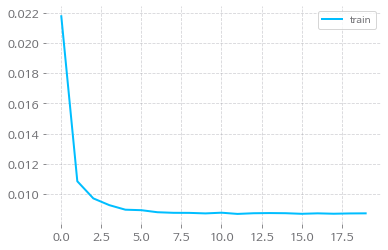

In [8]:
draw_history(history_1)

### 768 -> 128 AutoEncoder

In [9]:
model_name = "MyAE_128"
model_2 = get_Model(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.AdamW(model_2.parameters())
criterion = torch.nn.MSELoss()

summary(model_2, input_size=(768,), device="cuda")

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            98,432
├─Linear: 1-2                            99,072
├─ReLU: 1-3                              --
Total params: 197,504
Trainable params: 197,504
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            98,432
├─Linear: 1-2                            99,072
├─ReLU: 1-3                              --
Total params: 197,504
Trainable params: 197,504
Non-trainable params: 0

In [10]:
# train
print("============================= Train =============================")
history_2 = train(model_2, device, optimizer, criterion, 20, data_loader, None)

============================= Train =============================
993it [00:07, 134.50it/s, epoch=1/20, loss=0.035144]
993it [00:09, 106.80it/s, epoch=2/20, loss=0.031530]
993it [00:08, 116.53it/s, epoch=3/20, loss=0.032069]
993it [00:05, 180.38it/s, epoch=4/20, loss=0.029179]
993it [00:05, 193.94it/s, epoch=5/20, loss=0.029912]
993it [00:04, 202.88it/s, epoch=6/20, loss=0.031130]
993it [00:06, 157.28it/s, epoch=7/20, loss=0.029916]
993it [00:06, 161.53it/s, epoch=8/20, loss=0.031979]
993it [00:05, 192.00it/s, epoch=9/20, loss=0.029670]
993it [00:04, 205.53it/s, epoch=10/20, loss=0.031308]
993it [00:07, 137.68it/s, epoch=11/20, loss=0.031213]
993it [00:06, 164.20it/s, epoch=12/20, loss=0.030844]
993it [00:06, 163.83it/s, epoch=13/20, loss=0.030512]
993it [00:05, 170.37it/s, epoch=14/20, loss=0.031728]
993it [00:05, 167.75it/s, epoch=15/20, loss=0.031371]
993it [00:09, 103.67it/s, epoch=16/20, loss=0.031256]
993it [00:09, 103.60it/s, epoch=17/20, loss=0.031320]
993it [00:09, 109.46it/s,

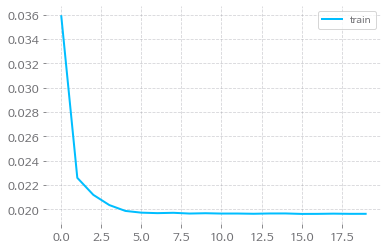

In [11]:
draw_history(history_2)

### 768 -> 64 AutoEncoder

In [12]:
model_name = "MyAE_64"
model_3 = get_Model(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.AdamW(model_3.parameters())
criterion = torch.nn.MSELoss()

summary(model_3, input_size=(768,), device="cuda")

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            49,216
├─Linear: 1-2                            49,920
├─ReLU: 1-3                              --
Total params: 99,136
Trainable params: 99,136
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            49,216
├─Linear: 1-2                            49,920
├─ReLU: 1-3                              --
Total params: 99,136
Trainable params: 99,136
Non-trainable params: 0

In [13]:
# train
print("============================= Train =============================")
history_3 = train(model_3, device, optimizer, criterion, 20, data_loader, None)

============================= Train =============================
993it [00:06, 154.67it/s, epoch=1/20, loss=0.051250]
993it [00:05, 174.02it/s, epoch=2/20, loss=0.045909]
993it [00:05, 187.48it/s, epoch=3/20, loss=0.045190]
993it [00:05, 177.14it/s, epoch=4/20, loss=0.044888]
993it [00:05, 183.26it/s, epoch=5/20, loss=0.045517]
993it [00:05, 183.03it/s, epoch=6/20, loss=0.044307]
993it [00:05, 178.14it/s, epoch=7/20, loss=0.044166]
993it [00:05, 168.97it/s, epoch=8/20, loss=0.046244]
993it [00:05, 180.27it/s, epoch=9/20, loss=0.044186]
993it [00:06, 143.09it/s, epoch=10/20, loss=0.046099]
993it [00:07, 129.00it/s, epoch=11/20, loss=0.043747]
993it [00:09, 104.62it/s, epoch=12/20, loss=0.045424]
993it [00:09, 102.92it/s, epoch=13/20, loss=0.044736]
993it [00:08, 114.11it/s, epoch=14/20, loss=0.045337]
993it [00:08, 120.31it/s, epoch=15/20, loss=0.044480]
993it [00:05, 197.62it/s, epoch=16/20, loss=0.047349]
993it [00:05, 197.73it/s, epoch=17/20, loss=0.044028]
993it [00:05, 182.65it/s,

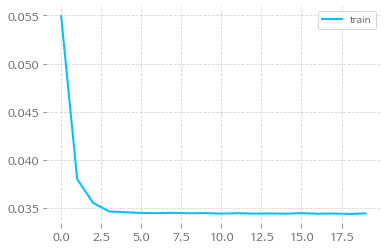

In [14]:
draw_history(history_3)

### 768 -> 32 AutoEncoder

In [47]:
model_name = "MyAE_32"
model_4 = get_Model(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.AdamW(model_4.parameters())
criterion = torch.nn.MSELoss()

summary(model_4, input_size=(768,), device="cuda")

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,608
├─Linear: 1-2                            25,344
├─ReLU: 1-3                              --
Total params: 49,952
Trainable params: 49,952
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,608
├─Linear: 1-2                            25,344
├─ReLU: 1-3                              --
Total params: 49,952
Trainable params: 49,952
Non-trainable params: 0

In [48]:
# train
print("============================= Train =============================")
history_4 = train(model_4, device, optimizer, criterion, 20, data_loader, None)

============================= Train =============================
993it [00:07, 133.03it/s, epoch=1/20, loss=0.073820]
993it [00:07, 140.45it/s, epoch=2/20, loss=0.068849]
993it [00:05, 168.80it/s, epoch=3/20, loss=0.065173]
993it [00:06, 148.23it/s, epoch=4/20, loss=0.065183]
993it [00:05, 176.91it/s, epoch=5/20, loss=0.064233]
993it [00:05, 179.81it/s, epoch=6/20, loss=0.064039]
993it [00:05, 180.34it/s, epoch=7/20, loss=0.064144]
993it [00:05, 173.98it/s, epoch=8/20, loss=0.063372]
993it [00:05, 187.85it/s, epoch=9/20, loss=0.064318]
993it [00:05, 189.66it/s, epoch=10/20, loss=0.063319]
993it [00:04, 209.70it/s, epoch=11/20, loss=0.064437]
993it [00:05, 188.68it/s, epoch=12/20, loss=0.063139]
993it [00:05, 167.78it/s, epoch=13/20, loss=0.064724]
993it [00:05, 195.94it/s, epoch=14/20, loss=0.064566]
993it [00:05, 185.03it/s, epoch=15/20, loss=0.063578]
993it [00:05, 168.65it/s, epoch=16/20, loss=0.065835]
993it [00:05, 175.77it/s, epoch=17/20, loss=0.063010]
993it [00:05, 184.82it/s,

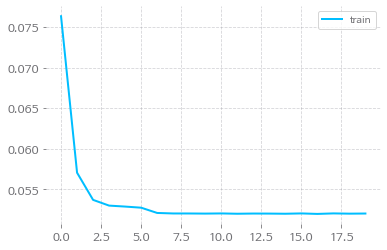

In [49]:
draw_history(history_4)

### Model save

In [50]:
torch.save(model_1, 'AE256.pt')
torch.save(model_2, 'AE128.pt')
torch.save(model_3, 'AE64.pt')
torch.save(model_4, 'AE32.pt')

### Update CSV

In [51]:
df = myDataset.data

# df['embedding256'] = pd.Series([[]] * len(df)) # dummy
# df['embedding128'] = pd.Series([[]] * len(df)) # dummy
# df['embedding64'] = pd.Series([[]] * len(df)) # dummy
df['embedding32'] = pd.Series([[]] * len(df)) # dummy

In [52]:
df.head()

,Q,A,embedding,embedding256,embedding128,embedding64,embedding32
0,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,"[-0.45895177, -0.16547588, -1.1699946, -0.5235...","[0.7029776, 0.09571235, -0.13331926, 0.4616024...","[0.7919962, 0.85061026, 1.375485, 0.3510425, 0...","[0.872061, 0.4354716, 0.4324086, 1.2460749, -0...",[]
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,"[-0.33981258, -0.34263593, -0.19506723, 0.2771...","[0.43760988, 0.45013106, 0.34973702, 0.4857529...","[0.35499853, 1.2580262, 0.6652683, 0.08005451,...","[0.9290237, 0.44735566, 0.23166454, 0.9519159,...",[]
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,"[-0.29754168, -0.046723098, 0.31551892, -0.247...","[0.7753483, 0.4311396, 0.1468041, 0.6344927, 0...","[0.52067024, -0.20803304, 0.789083, 0.20090854...","[0.6763892, 0.4358993, 0.30814424, 0.9880088, ...",[]
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,"[-0.46993116, 0.12696421, -0.34500095, 0.03754...","[0.4545657, 0.24327877, -0.05450859, 0.3835893...","[0.30212066, 0.49565285, 1.044461, 0.075045474...","[1.2143894, 0.29390815, 0.3434412, 1.2170162, ...",[]
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,"[0.29756892, -0.15757245, -0.4363715, -0.25249...","[0.53895783, 0.22691138, 0.07788866, -0.171293...","[-0.033911526, 0.1884734, 1.1081709, 0.7125091...","[0.7192032, 0.54352945, 0.04063937, 0.24342585...",[]


In [22]:
# 256dim
model_1.cpu()
df['embedding256'] = df['embedding'].map(lambda x : model_1.encode(torch.tensor(x)).detach().numpy())

In [23]:
# 128dim
model_2.cpu()
df['embedding128'] = df['embedding'].map(lambda x : model_2.encode(torch.tensor(x)).detach().numpy())

In [24]:
# 64dim
model_3.cpu()
df['embedding64'] = df['embedding'].map(lambda x : model_3.encode(torch.tensor(x)).detach().numpy())

In [53]:
# 32dim
model_4.cpu()
df['embedding32'] = df['embedding'].map(lambda x : model_4.encode(torch.tensor(x)).detach().numpy())

In [61]:
df.head()

,Q,A,embedding,embedding256,embedding128,embedding64,embedding32
0,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,"[-0.45895177, -0.16547588, -1.1699946, -0.5235...","[0.7029776, 0.09571235, -0.13331926, 0.4616024...","[0.7919962, 0.85061026, 1.375485, 0.3510425, 0...","[0.872061, 0.4354716, 0.4324086, 1.2460749, -0...","[0.3765331, 0.4333712, 0.30762458, 0.35876477,..."
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,"[-0.33981258, -0.34263593, -0.19506723, 0.2771...","[0.43760988, 0.45013106, 0.34973702, 0.4857529...","[0.35499853, 1.2580262, 0.6652683, 0.08005451,...","[0.9290237, 0.44735566, 0.23166454, 0.9519159,...","[-0.13359079, 0.7160391, -0.0029896572, 0.2504..."
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,"[-0.29754168, -0.046723098, 0.31551892, -0.247...","[0.7753483, 0.4311396, 0.1468041, 0.6344927, 0...","[0.52067024, -0.20803304, 0.789083, 0.20090854...","[0.6763892, 0.4358993, 0.30814424, 0.9880088, ...","[0.6171636, 0.53944504, 1.3225539, 0.20258132,..."
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,"[-0.46993116, 0.12696421, -0.34500095, 0.03754...","[0.4545657, 0.24327877, -0.05450859, 0.3835893...","[0.30212066, 0.49565285, 1.044461, 0.075045474...","[1.2143894, 0.29390815, 0.3434412, 1.2170162, ...","[0.5613419, 0.22808537, 0.6220126, 0.2772836, ..."
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,"[0.29756892, -0.15757245, -0.4363715, -0.25249...","[0.53895783, 0.22691138, 0.07788866, -0.171293...","[-0.033911526, 0.1884734, 1.1081709, 0.7125091...","[0.7192032, 0.54352945, 0.04063937, 0.24342585...","[0.71849537, 0.2457625, 0.9755603, 0.4419853, ..."


In [62]:
df.to_csv('BERT_ChatBot_Dataset_Base.csv', index=False)

In [55]:
df256 = df[['Q','A','embedding256']]
df128 = df[['Q','A','embedding128']]
df64 = df[['Q','A','embedding64']]
df32 = df[['Q','A','embedding32']]

In [56]:
df256.columns = ['Q','A','embedding']
df128.columns = ['Q','A','embedding']
df64.columns = ['Q','A','embedding']
df32.columns = ['Q','A','embedding']

In [57]:
df256.to_csv('BERT_ChatBot_Dataset_256.csv', index=False)
df128.to_csv('BERT_ChatBot_Dataset_128.csv', index=False)
df64.to_csv('BERT_ChatBot_Dataset_64.csv', index=False)
df32.to_csv('BERT_ChatBot_Dataset_32.csv', index=False)

In [58]:
data256 = pd.read_csv('BERT_ChatBot_Dataset_256.csv')
data128 = pd.read_csv('BERT_ChatBot_Dataset_128.csv')
data64 = pd.read_csv('BERT_ChatBot_Dataset_64.csv')
data32 = pd.read_csv('BERT_ChatBot_Dataset_32.csv')

strtotensor = lambda x : list(map(float, x[1:-1].replace('\n', '').replace('e -', 'e-').split()))

data256['embedding'] = data256['embedding'].map(strtotensor)
data128['embedding'] = data128['embedding'].map(strtotensor)
data64['embedding'] = data64['embedding'].map(strtotensor)
data32['embedding'] = data32['embedding'].map(strtotensor)

In [59]:
data32['embedding'][0]

[0.3765331,
 0.4333712,
 0.30762458,
 0.35876477,
 0.6179334,
 0.14657944,
 0.2714496,
 0.9003582,
 0.3954602,
 0.0545769,
 0.30774987,
 0.44536176,
 0.1939399,
 1.1345613,
 0.18388852,
 2.0108793,
 0.49562863,
 0.20259957,
 0.33128336,
 0.05180453,
 -0.10602854,
 0.03658326,
 0.5775585,
 0.01929516,
 0.13348165,
 0.04639779,
 -1.2882342,
 0.3470385,
 0.8388654,
 0.07214807,
 1.2241417,
 0.09875238]

In [63]:
# data256.to_csv('BERT_ChatBot_Dataset_256.csv', index=False)
# data128.to_csv('BERT_ChatBot_Dataset_128.csv', index=False)
data64.to_csv('BERT_ChatBot_Dataset_64.csv', index=False)
data32.to_csv('BERT_ChatBot_Dataset_32.csv', index=False)

In [45]:
a = m.encoder
a(torch.randn(768).cuda())

tensor([-0.6896,  0.1020,  0.1798, -0.5167,  0.0856,  0.3789, -0.2076, -0.5551,
         0.2013,  0.2461,  0.4048, -0.4176,  0.3773, -0.0289, -0.2264, -0.1841,
        -0.2070, -0.3099,  0.2866, -0.3933, -0.6093, -0.2933,  0.1286, -0.1346,
        -0.2776,  0.3269,  0.4665,  0.7484, -0.1130,  0.3023,  0.1562, -0.1394,
        -0.2360, -0.2048,  0.3151, -0.2931, -0.2187, -0.2884, -0.6644,  0.1698,
        -0.3819, -0.2462, -0.3828,  0.3629, -0.3976,  0.4046, -0.3100,  0.0227,
         0.3737, -0.1808, -0.8002,  0.2533, -0.1282,  0.2005,  0.1221, -0.6404,
        -0.2836, -0.4330, -0.8129, -0.6496, -0.4519,  0.6657, -0.2829, -0.1084],
       device='cuda:0', grad_fn=<AddBackward0>)

In [44]:
dim = 256
'AE'+str(dim)+'.pt'

'AE256.pt'